# Intruduction to LangGraph   
https://github.com/langchain-ai/langgraph/blob/main/examples/introduction.ipynb

In [2]:
# Setting up environment
from dotenv import load_dotenv
load_dotenv(r'D:\git\plinio_assistant\.env')

True

In [3]:
from typing import Annotated # This is what will allow us to pass the reductor function to our State class

from typing_extensions import TypedDict # So we can better 'lock' the datatypes for our state attributes

from langgraph.graph import StateGraph # The main structure of our graph
from langgraph.graph.message import add_messages # This is a prebuilt function that does the reductor job. Could be manually implemented.

In [4]:
# Creating the State class
class State(TypedDict):
    """
    The State class is a TypedDict that will hold the attributes of our state.
    The add_messages reductor function will guarantee that when a node simply returns the new message, it is appended instead of replacing the previous ones.
    """
    messages: Annotated[list, add_messages]

# As an additional consideration, the states should always have a a key-value structure.
# The reason to use TypedDicts or Pydantic models is to create additional validation when needed.

In [5]:
# This is the main structure of our graph. 
# We first create the 'scafolding' for it, so we can add the nodes and edges later.
# When we're done, we will .compile() it.
# These are based on NetworkX, so there's some graph traversal logic that makes sense here.

graph_builder = StateGraph(State)
# Ok, so what does this do: it prepares said 'scafolding'.
# But more importantly, is says that every node in the graph MUST receive the state as an input.
# Secondly, the nodes should return just the UPDATEs to the state, that'll be applied using the reductor function.
# They shouldnt return the whole state, just the updates.

In [6]:
# Now for an llm itself.
# The tutorial uses Anthropic, I'll use OpenAI

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o')

In [7]:
# This will be the first node of our graph.
# Nodes are callables. That's it.
# If it happens to be a model, good for them.

def chatbot_node_callable(state: State):
    """
    This will 'simply' invoke the model. The tutorial defines it in one line:
    return {"messages":[llm.invoke(state["messages"])]}
    but I'll split it up for clarity.

    Inputs:
    state: State > Note that it receives the FULL state. The graph is responsible for passing the correct attributes to the node (in this case, the state).

    Outputs:
    A key-value pair that'll be 'applied' to the state using the reductor function.
    There is no need to return the entire state schema, just the updates.
    In this case, we're updating the messages attribute, so:
    return {"messages": [The output of the model]}

    Note: The value should be a list, because the add_message reductor function is a beefed up version of list.extend().
    """
    # Models except a list of messages when invoked, at least in this context.
    messages = state["messages"] # They are stored here, so we get them
    response = llm.invoke(messages) # And pass them to the model
    # The response for these messages is an instance of BaseMessage, implemented in the langchain library.
    # Since langchain takes care of handling different types of messages (AIMessage, HumanMessage etc) we can use that abstraction
    # and simply append it.
    return {"messages": [response]} # Remembering to send it back as a list.

    # Later addition: from reading the add_message docs it _apparently_ accepts a single message as well.
    # Will try this when we run the graph.

In [8]:
# Now we start building on top of the scafolding.
# We add the node to the graph.

graph_builder.add_node('chatbot', chatbot_node_callable)

In [9]:
# We need to set the entry and finish points of our graph.
# Pretty sure the finish point is optional, and the graph just infers it from the last node in a sequence.
# But being explicit is always a good idea.

graph_builder.set_entry_point('chatbot') # A good convenience (courtesy of NetworkX) is that we can use the node name instead of the callable.
graph_builder.set_finish_point('chatbot')

In [10]:
# Great. Now its time to compile the graph.
# This'll allow us to actually use it.

graph = graph_builder.compile()

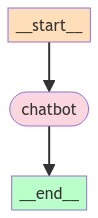

In [11]:
# Now this is a great helper function to visualize the graph.
# Should probably wrap it in a callable as well at some point.

from IPython.display import Image, display # Also, these imports should be at the top of an official .py; This is just a notebook tho.

try:
    display(Image(graph.get_graph().draw_mermaid_png())) # Also notice the get_graph() method is from the CompiledGraph class, not the StateGraph one.
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [16]:
# Adapting a bit the tutorial, I'll use both the invoke and the stream methods.
# Invoking runs everything before returning.

# To start, we need the user input
# In this first try I'll use langchain's HumanMessage class.
from langchain_core.messages import HumanMessage

user_input = HumanMessage("Hello, how are you?")

# Now remember, we must respect the schema the State class is expecting.
# In this case, it's a dictionary with a list of messages, so the reductor function can work its magic.
# I'm being unecessarily verbose here, but it's for clarity.
first_input = {"messages": [user_input]}
invocation_response = graph.invoke(first_input)

# Now we can print the response.
# Also for clarity, let's print the entire thing in a more pretty way.

from pprint import pprint
pprint(invocation_response)

{'messages': [HumanMessage(content='Hello, how are you?', id='05bd5810-26f7-4718-9c28-d83abd9e2dfb'),
              AIMessage(content="Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to help you with whatever you need. How can I assist you today?", response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 13, 'total_tokens': 47}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_ce0793330f', 'finish_reason': 'stop', 'logprobs': None}, id='run-5bcc3e7e-4b4b-4002-bd4a-2801830a00af-0', usage_metadata={'input_tokens': 13, 'output_tokens': 34, 'total_tokens': 47})]}


In [18]:
# Great. The response is also there, with the usual metadata.
# Just for clarity, what was returned was not a dict, it was the datatype from the state, but NOT the state.
# Pretty messy.
# TODO: Figure this out.

print(type(invocation_response))

<class 'langgraph.pregel.io.AddableValuesDict'>


In [19]:
# As I mentioned when building the graph, apparently the add_message reductor function can accept a single message.
# Let's try that, but that means I'll have to rebuild the graph to use the different node.
single_message_graph_builder = StateGraph(State)
def chatbot_node_single_message_callable(state: State):
    messages = state["messages"]
    response = llm.invoke(messages)
    return {"messages": response} # This is the difference.

single_message_graph_builder.add_node('chatbot', chatbot_node_single_message_callable)
single_message_graph_builder.set_entry_point('chatbot')
single_message_graph_builder.set_finish_point('chatbot')
single_message_graph = single_message_graph_builder.compile()

# Now we can invoke it again.
first_input_single_message = {"messages": user_input} # I can use the same input as before.
invocation_response_single_message = single_message_graph.invoke(first_input_single_message)

In [20]:
# Wouldn't you know it, it worked.
print(invocation_response_single_message)

{'messages': [HumanMessage(content='Hello, how are you?', id='05bd5810-26f7-4718-9c28-d83abd9e2dfb'), AIMessage(content="Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?", response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 13, 'total_tokens': 43}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_ce0793330f', 'finish_reason': 'stop', 'logprobs': None}, id='run-54411f4e-87ba-4e84-b52f-4acdbeddc5e0-0', usage_metadata={'input_tokens': 13, 'output_tokens': 30, 'total_tokens': 43})]}


In [22]:
# This is also an insane convenience given the Annotated nature of the State, plus the BaseMessage class:
# we can simply pass a tuple of (role, message) and it'll figure it out.
# I GUESS it is using this method behind the scenes: 
# https://api.python.langchain.com/en/latest/messages/langchain_core.messages.utils.convert_to_messages.html#langchain_core.messages.utils.convert_to_messages
# But I'm not sure how it is identifying the need to use it.

# Let's use the latter graph, to see if the convenience works in conjunction with the reductor function.
first_input_tuple = {"messages": ('user','Howdy, good sir!')} # The tuple.

invocation_response_tuple = single_message_graph.invoke(first_input_tuple)

In [23]:
# Apparently also worked. God bless abstractions.
print(invocation_response_tuple)

{'messages': [HumanMessage(content='Howdy, good sir!', id='4090cc66-bffc-4442-863f-1ad2c6447ab3'), AIMessage(content='Well, howdy to you too! How can I assist you today?', response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 12, 'total_tokens': 27}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_ce0793330f', 'finish_reason': 'stop', 'logprobs': None}, id='run-4abfde2d-19a1-4328-820f-cd84320d72fe-0', usage_metadata={'input_tokens': 12, 'output_tokens': 15, 'total_tokens': 27})]}


In [24]:
# Now for the streaming method.
# Expecting the same behavior, so I'll focus on the second example: using a BaseMessage subclass, but adding without a list.

# The .stream() method returns an iterator.
for event in single_message_graph.stream(first_input_single_message): # Using the single message graph, and the original input
    print(event) # The introduction notebook prints a .value attribute, but for starters I'll just print the event itself.

{'chatbot': {'messages': AIMessage(content="Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to help you! How can I assist you today?", response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 13, 'total_tokens': 43}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_4008e3b719', 'finish_reason': 'stop', 'logprobs': None}, id='run-da35e920-27b4-4e5b-bafd-8901e35c87bd-0', usage_metadata={'input_tokens': 13, 'output_tokens': 30, 'total_tokens': 43})}}


In [25]:
# Not that exciting for a single node graph.

# This concludes the basic graph building and invocation.

In [ ]:
# Part 2: TOOLS!
# The tutorial uses pre-built tools (namely, TavilySearch).
# I'll do that, but also will try to implement a custom tool since that is what I'll need for my actual project.